# Hybrid XGBoost → Transformer → GRU Model

2025-11-11 10:39:30.437807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762857570.649874      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762857570.710696      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-11 10:39:44.032318: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.0711 - loss: 3.0488 - val_accuracy: 0.2131 - val_loss: 2.5090
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2638 - loss: 2.2971 - val_accuracy: 0.5938 - val_loss: 1.4744
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6013 - loss: 1.3446 - val_accuracy: 0.8068 - val_loss: 0.8676
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7384 - loss: 0.8385 - val_accuracy: 0.8494 - val_loss: 0.5085
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8143 - loss: 0.5566 - val_accuracy: 0.8608 - val_loss: 0.4083
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8433 - loss: 0.4519 - val_accuracy: 0.9290 - val_loss: 0.2719
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8955 - loss: 0.3436 - val_accuracy: 0.9290 - val_loss: 0.2409
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9205 - loss: 0.2585 - val_accuracy: 0.

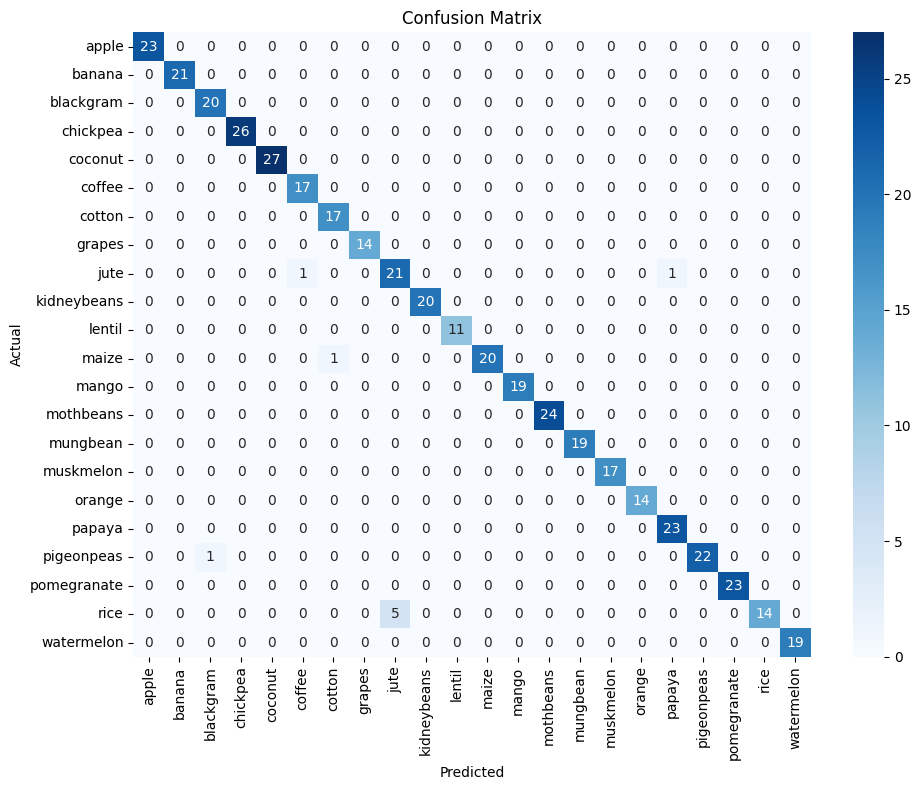

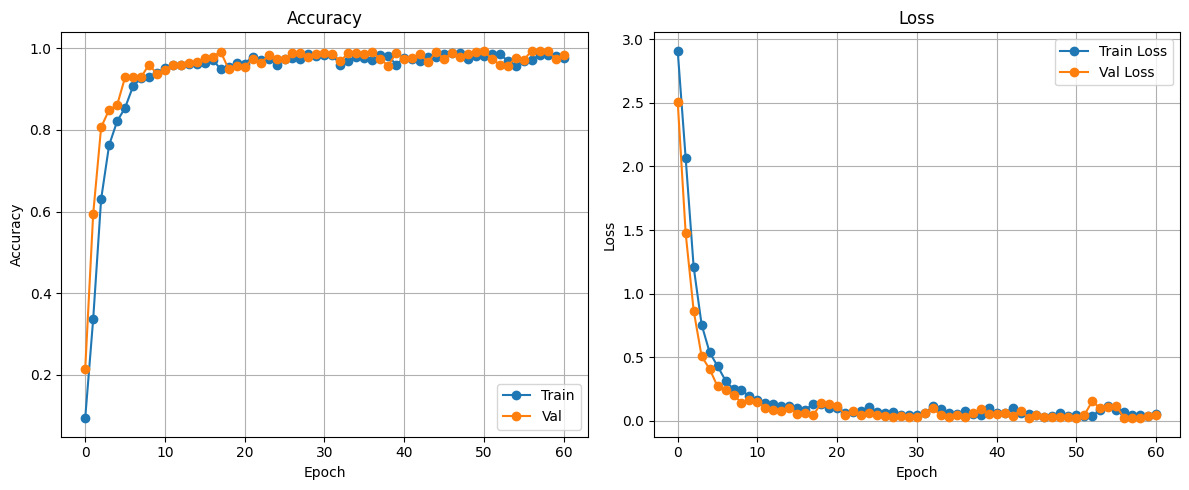

Model saved as 'xgb_transformer_gru_model.h5'


In [1]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, GRU, Dropout, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 1. Train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, objective='multi:softmax', num_class=len(np.unique(y_encoded)))
xgb_model.fit(X_train_full, y_train_full)

# 2. Select top N important features
importances = xgb_model.feature_importances_
top_indices = np.argsort(importances)[::-1][:5]  # Top 5 features

X_selected = X_scaled[:, top_indices]
X_selected_seq = X_selected.reshape((X_selected.shape[0], len(top_indices), 1))

# Final train/test split for neural model
X_train, X_test, y_train, y_test = train_test_split(X_selected_seq, y_cat, test_size=0.2, random_state=42)

# 3. Transformer + GRU Model
def xgb_transformer_gru_model(input_shape, num_classes, d_model=64, num_heads=2, ff_dim=128):
    inp = Input(shape=input_shape)
    x = Dense(d_model)(inp)

    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Add()([x, attn_out])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    x = GRU(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

model = xgb_transformer_gru_model(input_shape=X_train.shape[1:], num_classes=y_cat.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stop], verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Hybrid Test Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 6. Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model.save('xgb_transformer_gru_model.h5')
print("Model saved as 'xgb_transformer_gru_model.h5'")
